# Clustering and outlier detection
<hr>

<u>Objectives</u>
- Test clustering methods on the features extracted from the graph for nodes and transactions
- Test outlier detection methds on the features extracted from the graph for nodes and transactions
- Detect if the clustering is splitting some publicy known groups of addresses (exchange, pool, smart contracts etc.)
- Plot Clustering and outlier detection

<hr>


# 0 - Data preparation

Importing librairies

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from joblib import Parallel, delayed
import multiprocessing
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.covariance import EmpiricalCovariance, MinCovDet

loading different datasets :
- Publicy known adresses
- Features dataframe from the graph features generators

In [121]:
known = pd.read_csv('../data/known.csv')
rogues = pd.read_csv('../data/rogues.csv')
transactions = pd.read_csv('../data/edges.csv').drop('Unnamed: 0',1)
#Dropping features and fill na with 0
df = pd.read_csv('../data/features_full.csv').drop('Unnamed: 0',1).fillna(0)
df = df.set_index(['nodes'])
#build normalize values
data = scale(df.values)
n_sample = 10000

# I - Clustering Nodes
<hr>

Exploring clustering methods on the nodes featured dataset

## A - k-means

First a very simple kmeans method

In [3]:
#Define estimator / by default clusters = 6 an init = 10
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)

In [4]:
kmeans.fit(data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

### 1 - Parameters Optimization

#### a - Finding the best k 
code from http://www.slideshare.net/SarahGuido/kmeans-clustering-with-scikitlearn#notes-panel)

In [ ]:
%%time
#Determine your k range
k_range = range(1,14)
# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(data) for k in k_range]
# Pull out the centroids for each model
centroids = [X.cluster_centers_ for X in k_means_var]

In [ ]:
%%time
# Caluculate the Euclidean distance from each pont to each centroid
k_euclid=[cdist(data, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(data)**2)/data.shape[0]

#The between-cluster sum of squares
bss = tss - wcss

In [ ]:
%%time
plt.plot(k_range,bss/tss,'-bo')
plt.xlabel('number of cluster')
plt.ylabel('% of variance explained')
plt.title('Variance explained vs k')
plt.grid(True)
plt.show()

- Difficult to find an elbow criteria
- Other heuristic criteria k = sqrt(n/2)

#### b - Other heuristic method 
$k=\sqrt{\frac{n}{2}}$

In [ ]:
np.sqrt(data.shape[0]/2)

-> Weird

#### c - Silhouette Metrics for supervised ?

### 2 - Visualize with PCA reduction

code from scikit learn

In [85]:
##############################################################################
# Generate sample data


batch_size = 10
#centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = 6
#X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
X = PCA(n_components=2).fit_transform(data)

##############################################################################
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=6, n_init=10,random_state=2)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

##############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=6, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0,random_state=2)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0
mbk_means_labels = mbk.labels_
mbk_means_cluster_centers = mbk.cluster_centers_
mbk_means_labels_unique = np.unique(mbk_means_labels)

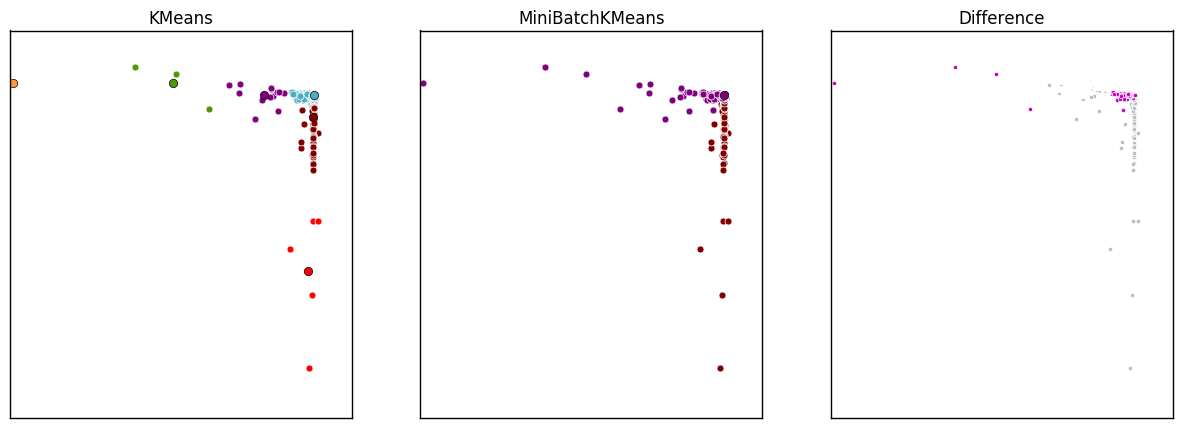

In [86]:
##############################################################################
# Plot result

fig = plt.figure(figsize=(15, 5))
colors = ['#4EACC5', '#FF9C34', '#4E9A06','#FF0000','#800000','purple']
#fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.

order = pairwise_distances_argmin(k_means_cluster_centers,
                                  mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.',markersize=10)
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
#plt.text(10,10,  'train time: %.2fs\ninertia: %f' % (
    #t_batch, k_means.inertia_))

# Plot result


# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.', markersize=10)
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
#plt.text(-5, 10, 'train time: %.2fs\ninertia: %f' %
         #(t_mini_batch, mbk.inertia_))

# Plot result



# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for l in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

## B - Mini batch

# II - Outlier Detection 
<hr>

Objectives : 
- Perform outlier detection on node data
- Test different methods (with perf metrics) 
- Plot outlier detection
- Tag transaction

Explain : Mahalanobis Distance

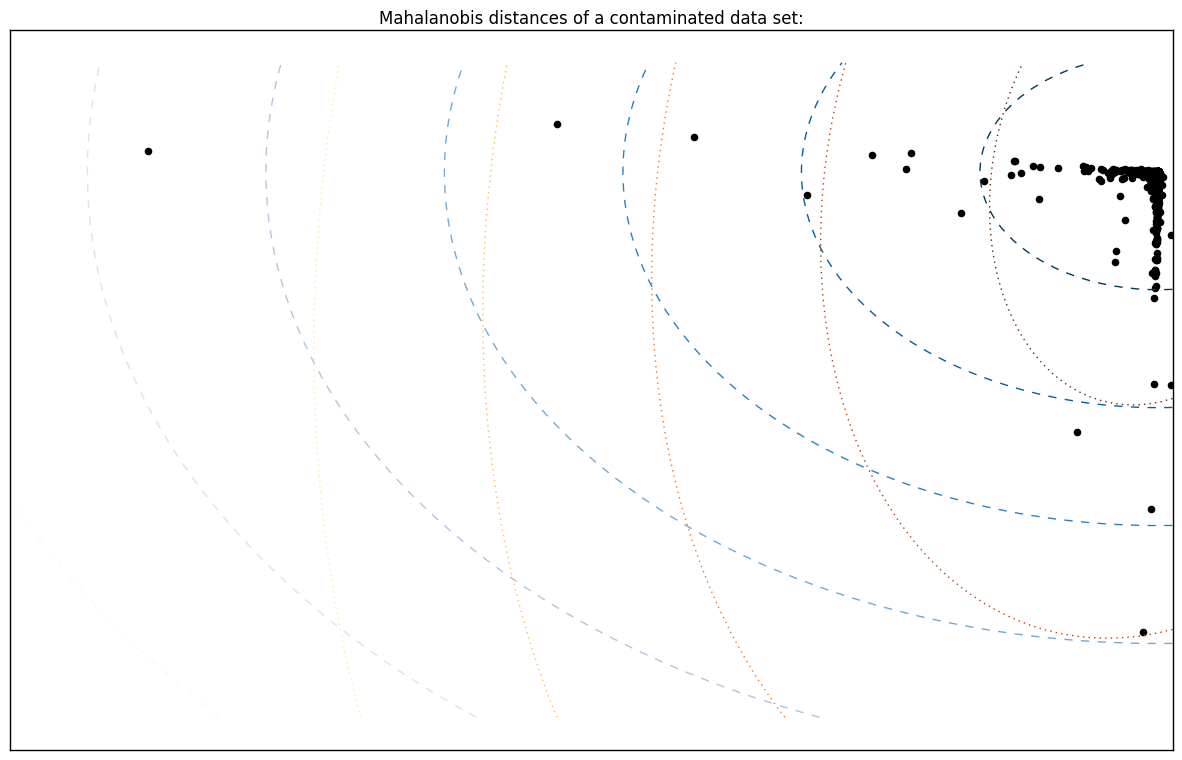

In [56]:
X = PCA(n_components=2).fit_transform(data)
# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(X)
robust_cov = MinCovDet().fit(X)


###############################################################################
# Display results
fig = plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=-.1, wspace=.4, top=.95, bottom=.05)

# Show data set
subfig1 = plt.subplot(1, 1, 1)
inlier_plot = subfig1.scatter(X[:, 0], X[:, 1],
                              color='black', label='points')
subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title("Mahalanobis distances of a contaminated data set:")

# Show contours of the distance functions
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = subfig1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')

mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, linestyles='dotted')


plt.xticks(())
plt.yticks(())
plt.show()

<hr>

# III - Look at the clusters

In [58]:
df.head(3)

,total_degree,degree_in,degree_out,unique_successors,unique_predecessors,mean_value_in,mean_value_out,std_value_in,std_value_out,ratio_in_timestamp,...,frequency_out,balance,mean_velocity_in,mean_velocity_out,std_velocity_in,std_velocity_out,mean_acceleration_in,mean_acceleration_out,min_path_to_rogue,min_path_from_rogue
nodes,,,,,,,,,,,,,,,,,,,,,
0,58793,58793,0,0,9161,2.025492e+20,0.000000e+00,4.908332e+22,0.0,1.476135,...,0.0,1.190847e+25,2.934858e+13,0.0,3.698298e+15,0.0,8.548336e+10,0.0,0.0,2.0
0xaeeb08aca66b2346006cd83cbb2c7d10c39e3301,2,1,1,1,1,5.689887e+18,5.688457e+18,0.000000e+00,0.0,1.000000,...,0.0,1.429602e+15,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,2347.0,1130.0
0x8dcca392c5d80d5ed8a566af8821002d12cd2f65,3,2,1,1,2,1.500095e+21,3.000000e+21,3.000050e+20,0.0,1.000000,...,0.0,1.900000e+17,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,2.0


In [132]:
k_means = KMeans(init='random', n_clusters=6, n_init=10, random_state=2)
clusters = k_means.fit_predict(data)

In [131]:
df['clusters'] = clusters
df.groupby('clusters').count()

,total_degree,degree_in,degree_out,unique_successors,unique_predecessors,mean_value_in,mean_value_out,std_value_in,std_value_out,ratio_in_timestamp,...,frequency_out,balance,mean_velocity_in,mean_velocity_out,std_velocity_in,std_velocity_out,mean_acceleration_in,mean_acceleration_out,min_path_to_rogue,min_path_from_rogue
clusters,,,,,,,,,,,,,,,,,,,,,
0,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
1,93065,93065,93065,93065,93065,93065,93065,93065,93065,93065,...,93065,93065,93065,93065,93065,93065,93065,93065,93065,93065
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,67,67,67,67,67,67,67,67,67,67,...,67,67,67,67,67,67,67,67,67,67
4,16531,16531,16531,16531,16531,16531,16531,16531,16531,16531,...,16531,16531,16531,16531,16531,16531,16531,16531,16531,16531
5,343472,343472,343472,343472,343472,343472,343472,343472,343472,343472,...,343472,343472,343472,343472,343472,343472,343472,343472,343472,343472


In [133]:
tagged = pd.merge(known,df,left_on='id',how='inner',right_index=True)

In [134]:
tagged.groupby('clusters').count().apply(lambda x: 100*x/float(x.sum()))['id']

clusters
0    11.827957
1    61.290323
2     1.075269
3     1.075269
5    24.731183
Name: id, dtype: float64

In [135]:
df.groupby('clusters').count().apply(lambda x: 100*x/float(x.sum()))['total_degree']

clusters
0     0.004193
1    20.537123
2     0.000221
3     0.014785
4     3.647979
5    75.795699
Name: total_degree, dtype: float64

In [136]:
rogues_tag = pd.merge(rogues,df,left_on='id',how='inner',right_index=True)

In [137]:
rogues_tag.groupby('clusters').count()['total_degree']

clusters
1    6
5    3
Name: total_degree, dtype: int64

Rogues and tagged are overrepresnetated in cluster 1

In [138]:
df.groupby('clusters').mean()

,total_degree,degree_in,degree_out,unique_successors,unique_predecessors,mean_value_in,mean_value_out,std_value_in,std_value_out,ratio_in_timestamp,...,frequency_out,balance,mean_velocity_in,mean_velocity_out,std_velocity_in,std_velocity_out,mean_acceleration_in,mean_acceleration_out,min_path_to_rogue,min_path_from_rogue
clusters,,,,,,,,,,,,,,,,,,,,,
0,2.612900e+05,4.042695e+04,220863.052632,7042.631579,7918.052632,7.212737e+20,1.098110e+22,5.273081e+21,2.178159e+22,1.890468,...,0.011008,3.381983e+24,8.516933e+16,2.825936e+20,4.798054e+18,3.794037e+20,1.967291e+14,6.388873e+18,2.315789,2.526316
1,2.138136e+01,2.118231e+01,0.199044,0.052243,2.076097,7.417071e+19,3.937509e+19,5.389531e+19,4.038152e+19,1.156968,...,0.000140,4.895816e+20,1.127456e+17,3.659001e+16,6.598585e+16,4.025345e+15,1.157953e+15,3.678747e+13,0.111728,4.103121
2,1.228371e+06,1.084279e+06,144092.000000,42729.000000,23113.000000,5.009805e+19,4.865686e+20,2.017054e+21,7.598143e+21,5.043979,...,0.004264,-1.579038e+25,2.566505e+15,3.213480e+17,7.026051e+17,3.929951e+19,3.696645e+11,1.529833e+16,2.000000,1.000000
3,3.786418e+02,2.353881e+02,143.253731,71.447761,181.477612,9.070842e+22,2.818395e+23,8.254031e+22,9.752651e+22,4.250715,...,0.004012,7.059440e+22,6.472854e+20,1.240381e+19,2.959118e+20,2.150052e+19,1.432339e+19,1.243209e+16,3.253731,2.791045
4,2.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,9.173332e+18,9.172241e+18,0.000000e+00,0.000000e+00,1.000000,...,0.000000,1.091282e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4317.845744,4316.450729
5,3.097724e+01,1.625887e+01,14.718373,2.183575,1.622426,1.340362e+20,2.098518e+20,7.264903e+19,1.237454e+20,0.967353,...,0.001317,-2.875345e+20,6.179641e+16,2.648585e+17,2.996784e+16,1.146132e+17,2.842660e+14,3.994207e+14,21.917123,22.265763


# IV - Tag transactions

In [139]:
transactions.head(4)

,from,gas,gasPrice,hash,timestamp,to,value
0,0xa1e4380a3b1f749673e270229993ee55f35663b4,21000,50000000000000,0x5c504ed432cb51138bcf09aa5e8a410dd4a1e204ef84...,2015-08-07 03:30:33,0x5df9b87991262f6ba471f09758cde1c0fc1de734,31337
1,0xbd08e0cddec097db7901ea819a3d1fd9de8951a2,21000,909808707606,0x19f1df2c7ee6b464720ad28e903aeda1a5ad8780afc2...,2015-08-07 03:36:53,0x5c12a8e43faf884521c2454f39560e6c265a68c8,19900000000000000000
2,0x63ac545c991243fa18aec41d4f6f598e555015dc,21000,500000000000,0x9e6e19637bb625a8ff3d052b7c2fe57dc78c55a15d25...,2015-08-07 03:37:10,0xc93f2250589a6563f5359051c1ea25746549f0d8,599989500000000000000
3,0x037dd056e7fdbd641db5b6bea2a8780a83fae180,21000,1000000000000,0xcb9378977089c773c074045b20ede2cdcc3a6ff562f4...,2015-08-07 03:43:03,0x7e7ec15a5944e978257ddae0008c2f2ece0a6090,100000000000000000000


In [153]:
df.head(20)

,total_degree,degree_in,degree_out,unique_successors,unique_predecessors,mean_value_in,mean_value_out,std_value_in,std_value_out,ratio_in_timestamp,...,balance,mean_velocity_in,mean_velocity_out,std_velocity_in,std_velocity_out,mean_acceleration_in,mean_acceleration_out,min_path_to_rogue,min_path_from_rogue,clusters
nodes,,,,,,,,,,,,,,,,,,,,,
0,58793,58793,0,0,9161,2.025492e+20,0.000000e+00,4.908332e+22,0.000000e+00,1.476135,...,1.190847e+25,2.934858e+13,0.000000e+00,3.698298e+15,0.000000e+00,8.548336e+10,0.000000e+00,0.0,2.0,0
0xaeeb08aca66b2346006cd83cbb2c7d10c39e3301,2,1,1,1,1,5.689887e+18,5.688457e+18,0.000000e+00,0.000000e+00,1.000000,...,1.429602e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2347.0,1130.0,5
0x8dcca392c5d80d5ed8a566af8821002d12cd2f65,3,2,1,1,2,1.500095e+21,3.000000e+21,3.000050e+20,0.000000e+00,1.000000,...,1.900000e+17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.0,5
0x945ac1e3ed6ae8270da0169e79621ad278b6e079,2,1,1,1,1,1.000000e+18,9.993354e+17,0.000000e+00,0.000000e+00,1.000000,...,6.645832e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.0,5.0,5
0x4c6df0a7c40b8746e6f23b14aca9aa4e8a7538d7,4,2,2,2,2,6.558730e+17,6.554530e+17,6.386689e+17,3.445470e+17,2.000000,...,8.400000e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.0,4.0,5
0x4ade66eff13240f425e4ecc51659dad06f644044,2,1,1,1,1,2.136258e+17,2.125758e+17,0.000000e+00,0.000000e+00,1.000000,...,1.050000e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.0,5.0,5
0xb02aac17b3484e2b6af054dd90b0ba756790fbad,2,1,1,1,1,2.832805e+17,2.782805e+17,0.000000e+00,0.000000e+00,1.000000,...,5.000000e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.0,4.0,5
0x0b9b2631c2e43028b82e3c5ac7f634c25bc1098a,2,1,1,1,1,1.599000e+19,1.598958e+19,0.000000e+00,0.000000e+00,1.000000,...,4.200000e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.0,2.0,5
0x961df528c61262878460cee1df19cfc7b21e5810,2,1,1,1,1,1.000000e+18,9.995800e+17,0.000000e+00,0.000000e+00,1.000000,...,4.200000e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.0,4.0,5


In [155]:
#write function
def get_cluster(node,df):
    return df.loc[node].clusters

In [156]:
get_cluster('0x037dd056e7fdbd641db5b6bea2a8780a83fae180',df)

5.0